In [279]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler


#import warnings
#warnings.filterwarnings("ignore")

%run optimizer.py

In [245]:
class LogisticRegression:

    def __init__(self):
        self.coeff = None

    def fit(self, X_train, Y_train, x0=np.array([-2.28, 0, 0, 0, 0, 0]), method="DFP", optimal_step=False):
        # def J(x):
        #     return np.sum([(1 - Y_train[i]) * x @ X_train[i,:] + np.log(1 + np.exp(-x @ X_train[i,:])) for i in range(Y_train.shape[0])])

        # def dJ(x):
        #     return np.sum(np.array([(1 - Y_train[i]) * X_train[i,:] - (X_train[i,:] / (np.exp(x @ X_train[i,:]) + 1)) for i in range(Y_train.shape[0])]),axis=0)

        def J(x):
            return (1 - Y_train) @ (x@X_train.T) + np.sum(np.log(1 + np.exp(-x @ X_train.T)))

        def dJ(x):
            return ( (1 - Y_train) - np.reciprocal(np.exp(x @ X_train.T) + 1) ) @ X_train

        self.coeff = optimize(x0, J, dJ, method, optimal_step)[-1]

    def predict(self, X_test):
        #sigmoid with calculated coefficients
        assert self.coeff is not None, "Model should be fitted first"
        return 1 / (1 + np.exp(-(self.coeff @ X_test.T)))

    def accuracy(self, target, predicted):
        predicted = np.rint(predicted)
        
        correct = 0
        for i in range(target.shape[0]):
            if target[i] == predicted[i]:
                correct += 1
        return correct / target.shape[0]

### Import train/test data

In [246]:
df_train = pd.read_csv('data/heart.csv',delimiter=';')
df_train['oldpeak'] = df_train['oldpeak'].str.replace(',','.')
df_train['bias'] = 1
df_train = df_train.astype(float)

y_train = df_train['target,'].to_numpy()
x_train = df_train.drop(['target,'], axis=1).to_numpy()

In [247]:
df_test = pd.read_csv('data/heart_test.csv', delimiter=";")
df_test['bias'] = 1
df_test = df_test.astype(float)

y_test = df_test['target'].to_numpy()
x_test = df_test.drop(['target'], axis=1).to_numpy()

### Fit, predict, accuracy

In [248]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
predicted = lr.predict(x_test)

C:\Users\Matus Balogh\AppData\Local\Temp\ipykernel_21956\3196883080.py:14: RuntimeWarning: overflow encountered in exp
  return (1 - Y_train) @ (x@X_train.T) + np.sum(np.log(1 + np.exp(-x @ X_train.T)))


In [249]:
lr.accuracy(y_test, predicted)

0.7

### Confusion Matrix

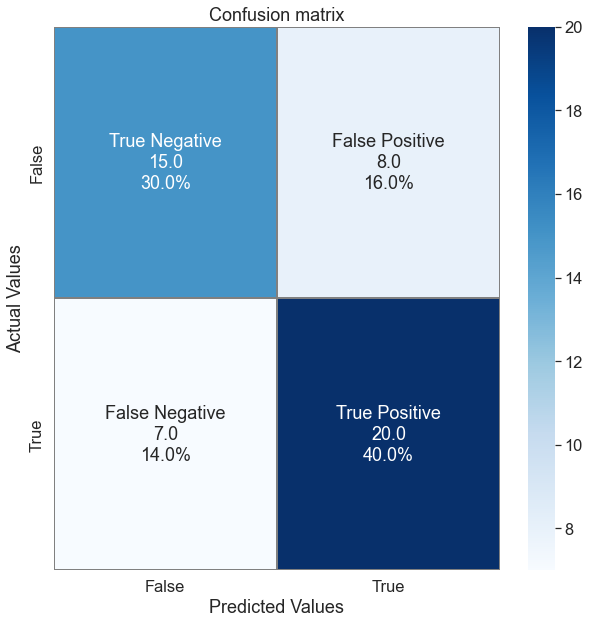

In [250]:
def confusion_matrix(test, predicted):
    rounded = np.rint(predicted)
    result = np.zeros((2, 2))

    for i in range(test.shape[0]):
        result[int(test[i])][int(rounded[i])] += 1

    labels = np.zeros((2, 2), dtype="U30")
    labels[0, 0] = f"True Negative\n{result[0, 0]}\n{100*result[0, 0]/result.sum()}%"
    labels[0, 1] = f"False Positive\n{result[0, 1]}\n{100*result[0, 1]/result.sum()}%"
    labels[1, 0] = f"False Negative\n{result[1, 0]}\n{100*result[1, 0]/result.sum()}%"
    labels[1, 1] = f"True Positive\n{result[1, 1]}\n{100*result[1, 1]/result.sum()}%"

    plt.subplots(figsize=(10, 10))
    sns.set(font_scale=1.5)
    ax = sns.heatmap(result, annot=labels, fmt="", cmap='Blues', linecolor="gray", linewidths=0.2)
    ax.set_title("Confusion matrix")
    ax.set_xlabel("Predicted Values")
    ax.set_ylabel("Actual Values")
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()
    
confusion_matrix(y_test, predicted)

### The best combination of columns for prediction

In [251]:
# Tu hladame kombinaciu stlpcov, podla ktorej model najlepsie predikuje ochorenie
df_train2 = df_train.drop(['target,'], axis=1)
accuracies = []
y_train_list = []
x_train_list = []
y_test_list = []
x_test_list = []
predicted_list = []

for i in range(1, 6):
  for col in combinations(df_train2, i):
    y_train_list.append(df_train['target,'].to_numpy())
    x_train_list.append(df_train[[*col]].to_numpy())
    y_test_list.append(df_test['target'].to_numpy())
    x_test_list.append(df_test[[*col]].to_numpy())

    lr.fit(x_train_list[-1], y_train_list[-1], x0 = np.array([-2.28] + (i-1)*[0]))
    predicted_list.append(lr.predict(x_test_list[-1]))
    accuracies.append((lr.accuracy(y_test_list[-1], predicted_list[-1]), col))


C:\Users\Matus Balogh\AppData\Local\Temp\ipykernel_21956\3196883080.py:14: RuntimeWarning: overflow encountered in exp
  return (1 - Y_train) @ (x@X_train.T) + np.sum(np.log(1 + np.exp(-x @ X_train.T)))
C:\Users\Matus Balogh\AppData\Local\Temp\ipykernel_21956\3196883080.py:17: RuntimeWarning: overflow encountered in exp
  return ( (1 - Y_train) - np.reciprocal(np.exp(x @ X_train.T) + 1) ) @ X_train
\\wsl$\Ubuntu\home\matusbalogh\LogisticRegression\optimizer.py:69: RuntimeWarning: divide by zero encountered in double_scalars
  deltaH = (1/np.inner(p,y))*np.outer(p,p) - (1/(y@H@y))*(H@np.outer(y,y)@H) #DFP formula
\\wsl$\Ubuntu\home\matusbalogh\LogisticRegression\optimizer.py:69: RuntimeWarning: invalid value encountered in multiply
  deltaH = (1/np.inner(p,y))*np.outer(p,p) - (1/(y@H@y))*(H@np.outer(y,y)@H) #DFP formula


In [252]:
# Ziskane presnosti predikcii zoradime
accuracies = np.asarray(accuracies, dtype='O')
sorter = np.argsort(accuracies, axis=0)[::-1][:,0]
accuracies_sorted = accuracies[sorter]

y_test_list = np.nan_to_num(y_test_list)
predicted_list = np.nan_to_num(predicted_list)
y_test_list_sorted = y_test_list[sorter]
predicted_list_sorted = predicted_list[sorter]

# print(accuracies)


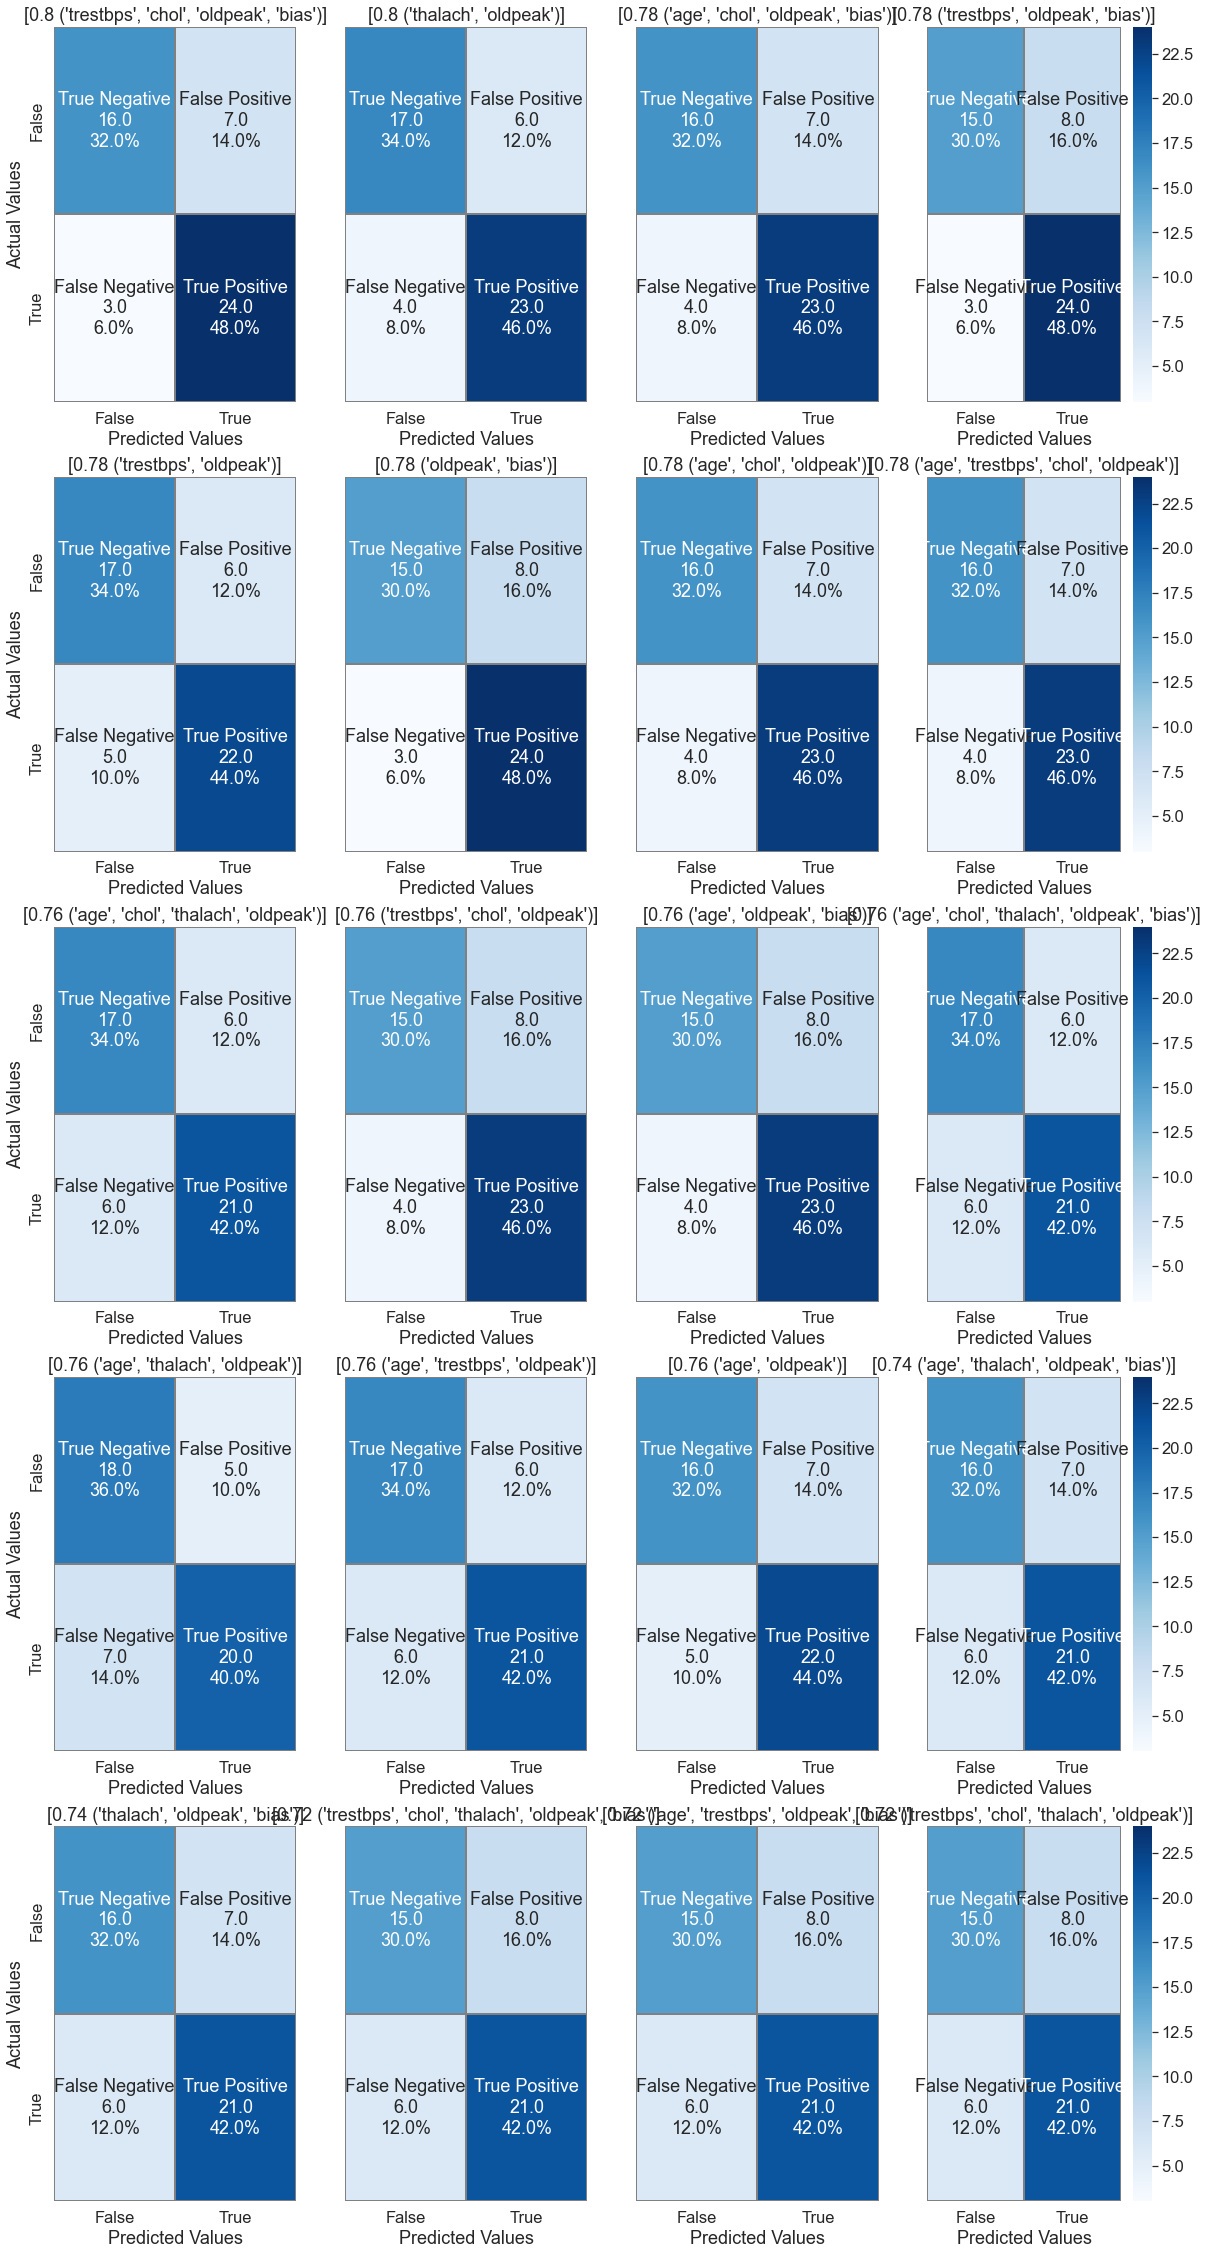

In [253]:
def confusion_matrices(test, predicted, accuracy):
    n = len(predicted)
    fig, ax = plt.subplots(nrows=int(np.ceil(n/4)), ncols=4, figsize=(20, 2*n))
    vmax, vmin = 0, test[0].shape[0]
    for j in range(n):
        rounded = np.rint(predicted[j])
        result = np.zeros((2, 2))

        for i in range(test[j].shape[0]):
            result[int(test[j][i])][int(rounded[i])] += 1

        labels = np.zeros((2, 2), dtype="U30")
        labels[0, 0] = f"True Negative\n{result[0, 0]}\n{100*result[0, 0]/result.sum()}%"
        labels[0, 1] = f"False Positive\n{result[0, 1]}\n{100*result[0, 1]/result.sum()}%"
        labels[1, 0] = f"False Negative\n{result[1, 0]}\n{100*result[1, 0]/result.sum()}%"
        labels[1, 1] = f"True Positive\n{result[1, 1]}\n{100*result[1, 1]/result.sum()}%"

        nmin = np.min(result)
        nmax = np.max(result)
        if nmin < vmin:
            vmin = nmin
        if nmax > vmax:
            vmax = nmax

        sns.set(font_scale=1.5)
        axj = ax[j//4, j%4]
        sns.heatmap(result, ax=axj, annot=labels, fmt="", cmap='Blues', linecolor="gray", linewidths=0.2,
                    cbar=not (j+1)%4, vmin=vmin, vmax=vmax, yticklabels=not j%4)
        axj.set_title(f"{accuracy[j]}")
        axj.set_xlabel("Predicted Values")
        axj.xaxis.set_ticklabels(['False','True'])
        if not j % 4:
            axj.yaxis.set_ticklabels(['False','True'])
            axj.set_ylabel("Actual Values")
    plt.show()

fltr = np.where(accuracies_sorted[:,0] > 0.7)[-1][-1]
confusion_matrices(y_test_list_sorted[:fltr], np.nan_to_num(predicted_list_sorted[:fltr]), accuracies_sorted[:fltr])


Normalized data

In [296]:
x_train_norm, x_test_norm = np.copy(x_train), np.copy(x_test)

In [297]:
scaler = MinMaxScaler().fit(x_train_norm)
x_train_norm = scaler.transform(x_train_norm)
x_test_norm = scaler.transform(x_test_norm)
x_test_norm.mean(axis=0)


array([0.54208333, 0.34207547, 0.25625571, 0.58931298, 0.16580645,
       0.        ])

In [298]:
lr2 = LogisticRegression()
lr2.fit(x_train_norm, y_train)
predicted = lr2.predict(x_test_norm)
lr2.accuracy(y_test, predicted)

0.7

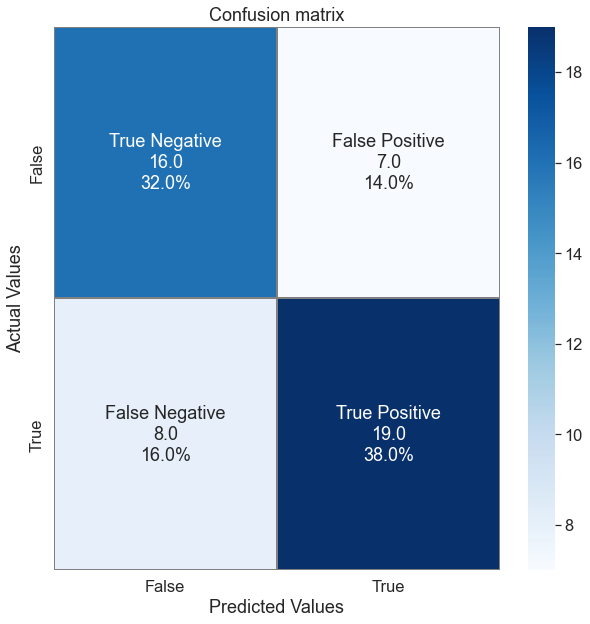

In [299]:
confusion_matrix(y_test, predicted)

# este o jedneho False Negative horsie